# 🚀 Barrier Reef YOLOv5 [Training]

### Hi kagglers, This is `Training` notebook using `YOLOv5`.


### Other notebooks in the competition
- [Barrier Reef YOLOv5 [Inference]](https://www.kaggle.com/ammarnassanalhajali/barrier-reef-yolov5-inference/edit)



### Please if this kernel is useful, <font color='red'>please upvote !!</font>

# 📚 YOLOv5
YOLO, "You Only Look Once", has a long and succesful history with real time object detection.

#  ⬇️ Download YOLOv5
Clone this repo and install requirements.txt dependencies, including Python>=3.8 and PyTorch>=1.7.

In [ ]:
# Download YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

# Install dependencies
%pip install -qr requirements.txt  

# change directory
%cd ../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
!add-apt-repository ppa:ubuntu-toolchain-r/test -y
!apt-get update
!apt-get upgrade libstdc++6 -y

# 🔨 Weights & Biases
* Weights & Biases is a set of tools that tracks machine learning experiments, visualizes metrics, and shares results.
* Weights & Biases is directly integrated into YOLOv5, providing experiment metric tracking, model and dataset versioning, rich model prediction visualization, and more.

In [ ]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("keyme")
! wandb login $api_key

# ☀️ Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from itertools import groupby
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import pickle
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
import glob
from os import listdir
from os.path import isfile, join
from glob import glob
import yaml

import shutil
from shutil import copyfile
import sys

from joblib import Parallel, delayed

# --- Read data ---
TRAIN_PATH = '/kaggle/input/tensorflow-great-barrier-reef'

# 🔨 Functions

In [ ]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes
def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row
def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def coco2yolo(image_height, image_width, bboxes):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes
def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [0, 0, 255], thickness=tf, lineType=cv2.LINE_AA)



def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

np.random.seed(8)
colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
colors=(255,0,0)

# 🍮 Loading Data

In [ ]:
# Read in the data CSV files
df = pd.read_csv("/kaggle/input/tensorflow-great-barrier-reef/train.csv")
df.head(5)


# BBoxes
##### 📌 Note 
> We can see there are many images without any BBox. 

In [ ]:
df["NumBBox"]=df['annotations'].apply(lambda x: str.count(x, 'x'))
df.head(5)

In [ ]:
print(df["NumBBox"].unique())

In [ ]:
df_train=df[df["NumBBox"]>0]
df_train.sample(2)

In [ ]:
print(df_train['NumBBox'].sum())

> We have just 4919 images with 11898 BBox, we will use them in training.

In [ ]:
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)
df_train.sample(2)

# Size of Images
##### 📌 Note 
> All images have Width=1280 & Height=720 

In [ ]:
df_train["Width"]=1280
df_train["Height"]=720
df_train.sample(2)

# Path of Images

In [ ]:
df_train = df_train.progress_apply(get_path, axis=1)
df_train.sample(2)

# 🌈 Visualizing BBoxes

In [ ]:
df_v = df_train[(df_train.NumBBox==13)].sample(2) 
fig,ax = plt.subplots(1,2,figsize=(30,20))
i=0;
for index, row in df_v.iterrows():
    img           = load_image(row.image_path)
    image_height  = row.Height
    image_width   = row.Width
    bboxes_coco   = np.array(row.bboxes)
    bboxes_yolo   = coco2yolo(image_height, image_width, bboxes_coco)
    names         = ['COTS']*len(bboxes_coco)
    labels        = [0]*len(bboxes_coco)
    im=draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2)
    ax[i].imshow(im)
    ax[i].axis('OFF')
    i=i+1

# 🍚 Splitting Dataset

In [ ]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 5)
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y = df_train.video_id.tolist(), groups=df_train.sequence)):
    df_train.loc[val_idx, 'fold'] = fold
display(df_train.fold.value_counts())

In [ ]:
Selected_Fold=1 #0..4
t_df = df_train.query("fold!=@Selected_Fold")
v_df = df_train.query("fold==@Selected_Fold")
print(t_df['NumBBox'].sum())
print(v_df['NumBBox'].sum())
print(v_df['NumBBox'].sum()/t_df['NumBBox'].sum())
print("##############################")
print(df_train.groupby('video_id').size())
print("---------------")
print(t_df.groupby('video_id').size())
print("---------------")
print(v_df.groupby('video_id').size())


## 🍚 Organize Directories

I organized train and val images and labels according to the example below.

```
/Kaggle/working
    /COTS
         /images
             /train/img0.jpg
             /val
         /labels
             /train/img0.txt
             /val
    /yolov5
```

In [ ]:
os.makedirs('COTS/images/train', exist_ok=True)
os.makedirs('COTS/images/valid', exist_ok=True)
os.makedirs('COTS/labels/train', exist_ok=True)
os.makedirs('COTS/labels/valid', exist_ok=True)

In [ ]:
for i in tqdm(range(len(df_train))):
    row = df_train.loc[i]
    if row.fold != Selected_Fold:
        copyfile(f'{row.image_path}', f'COTS/images/train/{row.image_id}.jpg')
    else:
        copyfile(f'{row.image_path}', f'COTS/images/valid/{row.image_id}.jpg') 

In [ ]:
list1 = os.listdir('/kaggle/working/COTS/images/train') # dir is your directory path
number_files1 = len(list1)
print("Number of images in ./COTS/images/train folder",number_files1)
list2 = os.listdir('/kaggle/working/COTS/images/valid') # dir is your directory path
number_files2 = len(list2)
print("Number of images in ./COTS/images/valid folder",number_files2)

# 🍜 Create `Data.YAML` file

The `data.yaml`, is the dataset configuration file that defines:

1. the dataset root directory and relative paths to train/val/test image directories (or paths to *.txt files with image paths).
1. the number of classes.
1. a list of class names.

> 📍 Note: The `data.yaml` is created in the `yolov5/data` directory as required. 

In [ ]:
import yaml
with open('/kaggle/working/train.txt', 'w') as f:
    for path in glob('/kaggle/working/COTS/images/train/*'):
        f.write(path+'\n')
            
with open('/kaggle/working/val.txt', 'w') as f:
    for path in glob('/kaggle/working/COTS/images/valid/*'):
        f.write(path+'\n')

data = dict(
    train = '/kaggle/working/COTS/images/train',
    val = '/kaggle/working/COTS/images/valid',
    
    nc    = 1, # number of classes
    names =  ['cots'] # classes
    )

with open('/kaggle/working/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

%cat /kaggle/working/yolov5/data/data.yaml

In [ ]:
%%writefile /kaggle/working/hyp.yaml
lr0: 0.01114
lrf: 0.10357
momentum: 0.91893
weight_decay: 0.00051
warmup_epochs: 3.10145
warmup_momentum: 0.85195
warmup_bias_lr: 0.08903
box: 0.05204
cls: 0.46428
cls_pw: 0.96079
obj: 1.02185
obj_pw: 1.0346
iou_t: 0.2
anchor_t: 4.367
fl_gamma: 0.0
hsv_h: 0.0167
hsv_s: 0.71065
hsv_v: 0.39625
degrees: 0.0
translate: 0.09844
scale: 0.48905
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 0.9581
mixup: 0.0
copy_paste: 0.0

## 🍮 Create Labels for YOLOv5

To label your images,a `.txt` file with the same name of the image,will be created (if no objects in image, no *.txt file is required)
The *.txt file specifications are:

* One row per object
* Each row is class x_center y_center width height format.
* Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
* Class numbers are zero-indexed (start from 0).

> 📍 Note: We don't have to remove the images without bounding boxes from the training or validation sets. 

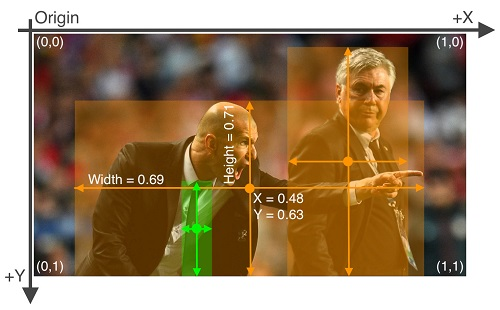

The label file corresponding to the above image contains 2 persons (class 0) and a tie (class 27):

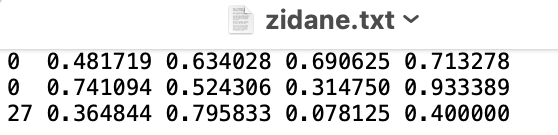

In [ ]:
all_bboxes = []
for row_idx in tqdm(range(df_train.shape[0])):
    row = df_train.iloc[row_idx]
    # Get image
    image_name = row.image_id
    image_height = row.Height
    image_width  = row.Width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = [0]*num_bbox
    if row.fold != Selected_Fold:
        file_name = f'/kaggle/working/COTS/labels/train/{image_name}.txt'
    else:
        file_name = f'/kaggle/working/COTS/labels/valid/{image_name}.txt'

    with open(file_name, 'w') as f:
        bboxes_yolo  = coco2yolo(image_height, image_width, bboxes_coco)
        bboxes_yolo  = np.clip(bboxes_yolo, 0, 1)
        all_bboxes.extend(bboxes_yolo)
        for bbox_idx in range(len(bboxes_yolo)):
            bb=str(bboxes_yolo[bbox_idx])
            bb=bb[1:-1]
            annot = str(str(labels[bbox_idx])) + ' ' + bb + '\n'
            annot = ''.join(annot)
            annot = annot.strip('')
            f.write(annot)

In [ ]:
list1 = os.listdir('/kaggle/working/COTS/labels/train') # dir is your directory path
number_files1 = len(list1)
print("Number of txt file in ./COTS/labels/train folder",number_files1)
list2 = os.listdir('/kaggle/working/COTS/labels/valid') # dir is your directory path
number_files2 = len(list2)
print("Number of txt file in ./COTS/labels/valid folder",number_files2)


In [ ]:
%cat '/kaggle/working/COTS/labels/train/{list1[10]}'

# 📦 Select a Model
Select a pretrained model to start training from. 
* Here we select YOLOv5s, the smallest and fastest model available.
* I will try YOLO5s

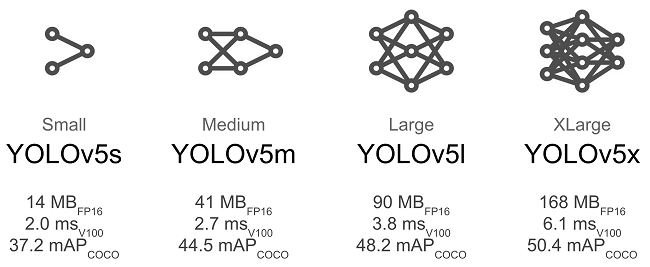

# 🚅 Train with W&B

In [ ]:
%cd yolov5/

All training results are saved to runs/train/ with incrementing run directories, i.e. runs/train/exp2, runs/train/exp3 etc. 

### 🍘 Hyperparameters

In [ ]:
BATCH_SIZE =8
EPOCHS = 15
IMG_SIZE=768 #1280

In [ ]:
#best_weights = '/kaggle/input/nfl-weights/yolov5/kaggle-reef/exp/weights/best.pt' --weights {best_weights} \
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --hyp /kaggle/working/hyp.yaml\
                 --weights yolov5x6.pt \
                 --project kaggle-Reef 

# Removing Files

In [ ]:
%cd "../"
path = "COTS"
shutil.rmtree(path)

# 🖼️ Visualizing and Results

* Weights & Biases (W&B) is now integrated with YOLOv5 for real-time visualization and cloud logging of training runs. This allows for better run comparison and introspection, as well improved visibility and collaboration among team members.

* During training you will see live updates at https://wandb.ai, and you can create Detailed Reports of your results using the W&B Reports tool.
* To see my project on Weights & Biases (W&B) [here](https://wandb.ai/ammaralhajali/kaggle-Reef)

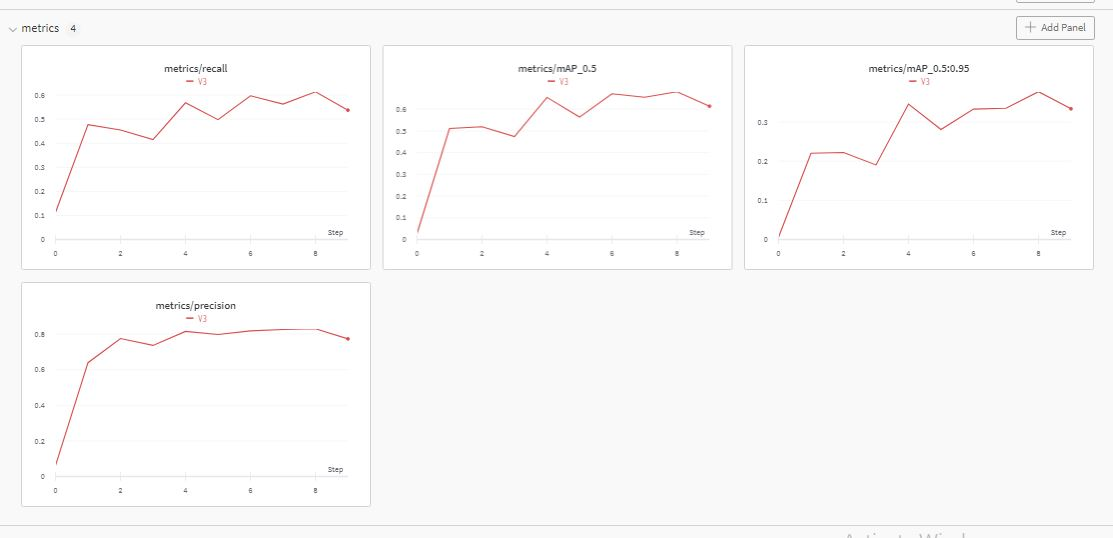

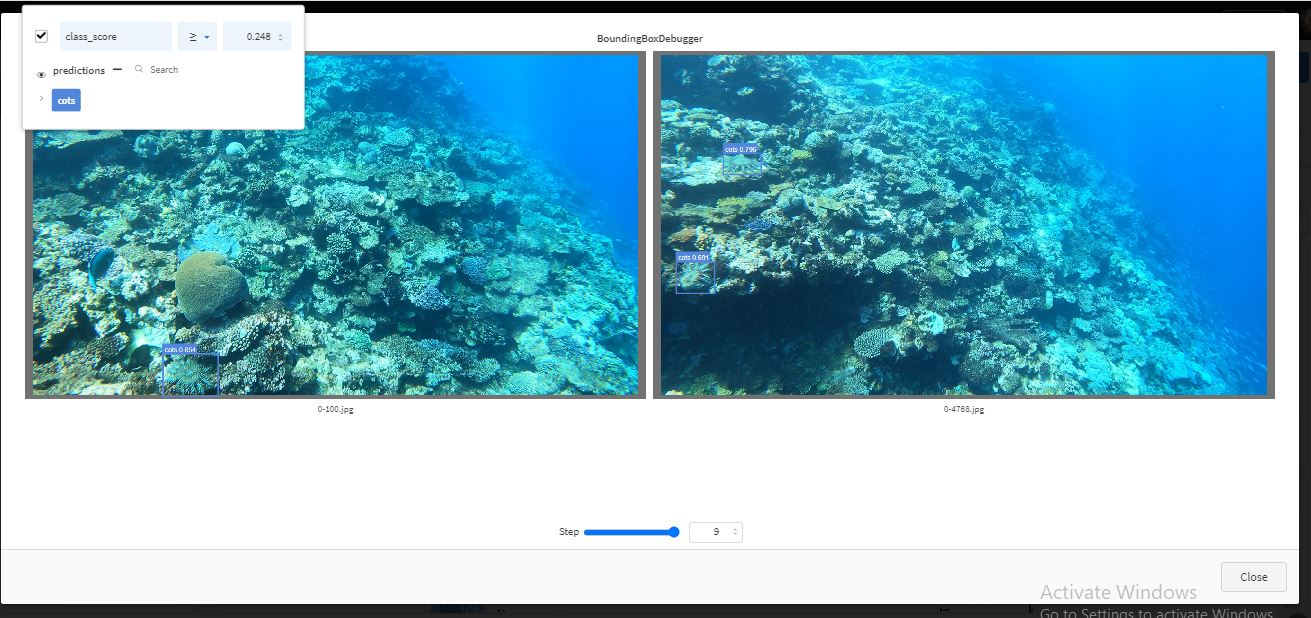

### Class Distribution

In [ ]:
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-Reef/exp/labels.jpg'));


### Batch Image

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-Reef/exp/train_batch0.jpg'))


## P Curve

In [ ]:
#!ls /kaggle/working/yolov5/kaggle-NFL/exp
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-Reef/exp/P_curve.png'));

## PR Curve

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-Reef/exp/PR_curve.png'));

## F1 Curve

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-Reef/exp/F1_curve.png'));

## R Curve

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-Reef/exp/R_curve.png'));

### GT Vs Pred

In [ ]:
ig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'/kaggle/working/yolov5/kaggle-Reef/exp/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'/kaggle/working/yolov5/kaggle-Reef/exp/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'/kaggle/working/yolov5/kaggle-Reef/exp/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'/kaggle/working/yolov5/runs/kaggle-Reef/val_batch{row}_pred.jpg', fontsize = 12)

### (Loss, Map) Vs Epoch


In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-Reef/exp/results.png'));

### Confusion Matrix

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/kaggle-Reef/exp/confusion_matrix.png'));

### Please if this kernel is useful, <font color='red'>please upvote !!</font>

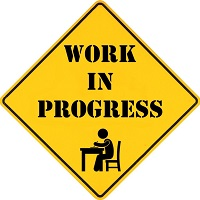

# References

1. https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train
